In [435]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [436]:
# MSET Linear Regression
"""
Created on Thur Feb 16 13:53:30 2023
@author: Junhyun
"""


class MSET_LinearRegression():

    def __init__(self):
        self.model_list = None
        self.normalizeScaler = StandardScaler()
        # self.covScaler = Covariance_scaler()
        self.trScore = None
        self.tsScore = None
        self.varTrScore = None
        self.varTsScore = None
        self.cl = None
        self.varucl = []
        self.varlcl = []

    def fit(self, trdat):

        if isinstance(trdat, pd.core.frame.DataFrame):
            trdat = np.array(trdat)

        train_intercept = np.ones((trdat.shape[0], 1))

        # 초기값 선언
        y_hat_tr = np.zeros((trdat.shape[0], trdat.shape[1]))

        # train data 학습
        self.model_list = np.zeros([trdat.shape[1], trdat.shape[1]])
        for i in range(trdat.shape[1]):
            idx = np.arange(trdat.shape[1]).tolist()
            idx.remove(i)
            model = np.linalg.pinv(np.concatenate((train_intercept, trdat[:, idx]), axis=1).transpose() @ np.concatenate(
                (train_intercept, trdat[:, idx]), axis=1)) @ np.concatenate((train_intercept, trdat[:, idx]), axis=1).transpose()  @ trdat[:, i]

            # 예측값
            y_hat_tr[:, i] = np.concatenate(
                (train_intercept, trdat[:, idx]), axis=1) @ model

            # 모델 저장
            self.model_list[:, i] = model

        self.varTrScore = trdat - y_hat_tr

        self.normalizeScaler.fit(self.varTrScore)
        scaled_varTrScore = self.normalizeScaler.transform(
            self.varTrScore)  # 변환
        self.trScore = L2norm(scaled_varTrScore).sum(axis=1)  # L2norm

        return {'trScore': self.trScore, 'varTrScore': self.varTrScore}

    def predict(self, tsdat):

        if isinstance(tsdat, pd.core.frame.DataFrame):
            tsdat = np.array(tsdat)

        test_intercept = np.ones((tsdat.shape[0], 1))

        # 초기값 선언
        y_hat_ts = np.zeros((tsdat.shape[0], tsdat.shape[1]))

        for i in range(tsdat.shape[1]):
            idx = np.arange(tsdat.shape[1]).tolist()
            idx.remove(i)
            y_hat_ts[:, i] = np.concatenate(
                (test_intercept, tsdat[:, idx]), axis=1) @ self.model_list[:, i]

        self.varTsScore = tsdat - y_hat_ts
        scaled_varTsScore = self.normalizeScaler.transform(
            self.varTsScore)  # 변환
        self.tsScore = L2norm(scaled_varTsScore).sum(axis=1)  # L2norm

        return {'tsScore': self.tsScore, 'varTsScore': self.varTsScore}

    def bootLimit(self, alpha=0.05, bootstrap=100):

        # 각 변수 별 CL
        for i in range(self.varTrScore.shape[1]):
            self.varucl.append(bootstrap_limit(
                self.varTrScore[:, i], alpha=alpha/2, upper=True, bootstrap=bootstrap))
            self.varlcl.append(bootstrap_limit(
                self.varTrScore[:, i], alpha=alpha/2, upper=False, bootstrap=bootstrap))

        # 합산 CL
        self.cl = bootstrap_limit(
            self.trScore, alpha=alpha, bootstrap=bootstrap, upper=True)

        return{'CL': self.cl, 'varUCL': self.varucl, 'varLCL': self.varlcl}

# ===========================================================
# from sklearn.datasets import load_iris
# df = load_iris(as_frame=True)
# dat = df['data']
# trdat = dat
# tsdat = dat
# mset_reg = MSET_LinearRegression()
# fit = mset_reg.fit(trdat)
# pred = mset_reg.predict(tsdat)
# cl_list = mset_reg.bootLimit(alpha=0.05, bootstrap=100)
# plt.figure(figsize=(12,4))
# plt.plot(pred['tsScore'], color='blue')
# plt.axhline(y=cl_list['CL'], color='red')
# plt.show()
# ===========================================================


## Process of RUL Prediction
### Data Import -> Signal Processing -> Anomaly Detection -> Degradation Factor -> RUL Prediction
</br>

## Data Import

In [437]:
os.chdir('E:\\연구실\\데이터\\예지보전\\IMS bearing data\\originalData\\archive\\2nd_test')
file_list = glob.glob("**/*.39", recursive=True)

In [438]:
df = pd.read_csv(file_list[0], sep='\t',header=None)
df.head()

,0,1,2,3
0,-0.049,-0.071,-0.132,-0.010
1,-0.042,-0.073,-0.007,-0.105
2,0.015,0.000,0.007,0.000
3,-0.051,0.020,-0.002,0.100
4,-0.107,0.010,0.127,0.054


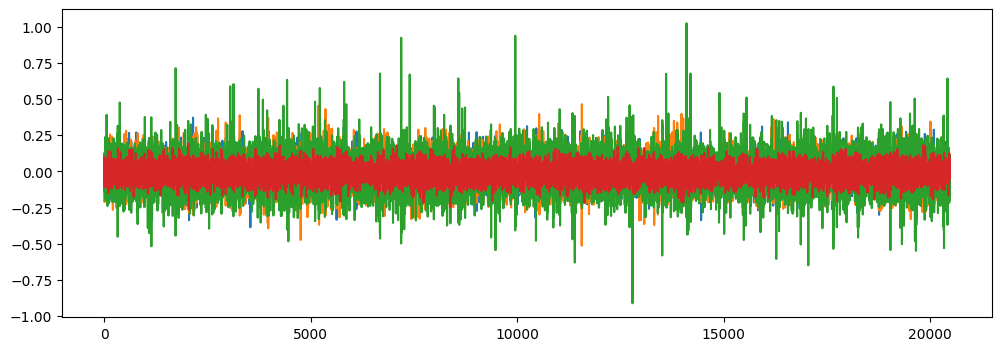

In [439]:
plt.figure(figsize=(12,4))
plt.plot(df)
plt.show()

## Signal Processing

In [440]:
def rms(stats):
    return(np.sqrt(np.mean(stats**2, axis=0)))
rms(df)

0    0.074179
1    0.090944
2    0.109404
3    0.054103
dtype: float64

In [441]:
rms_arr = np.array([])
for file in file_list:
    df = pd.read_csv(file, sep='\t',header=None)
    rms_value = rms(df.values)
    rms_arr = np.concatenate([rms_arr, rms_value], axis=0)
rms_arr = rms_arr.reshape(len(file_list), 4)

rms_df = pd.DataFrame(rms_arr, columns=['ch1','ch2','ch3','ch4'])
rms_df.to_csv('E:\\연구실\\데이터\\예지보전\\IMS bearing data\\RMS_bearing.csv', index=None)
# rms_df = None

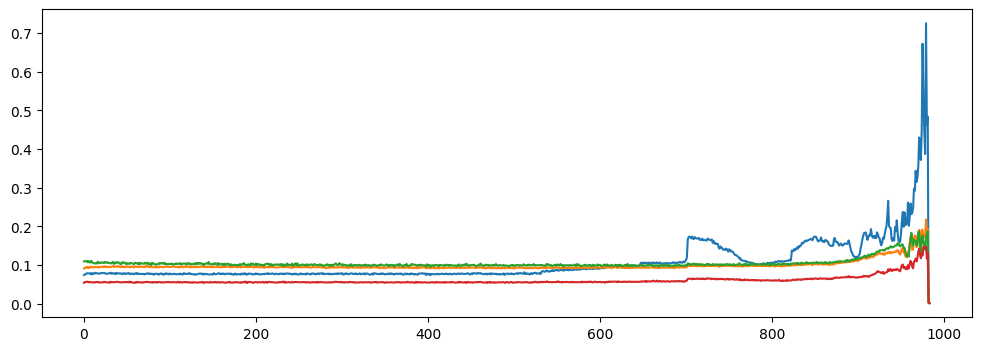

In [442]:
plt.figure(figsize=(12,4))
plt.plot(rms_df.values)
plt.show()

## Anomaly Detection (MSET)

In [443]:
rms_df = pd.read_csv('E:\\연구실\\데이터\\예지보전\\IMS bearing data\\RMS_bearing.csv')
rms_df.head()

,ch1,ch2,ch3,ch4
0,0.074179,0.090944,0.109404,0.054103
1,0.075382,0.093419,0.109817,0.056101
2,0.076230,0.093718,0.109861,0.056145
3,0.078724,0.092947,0.110667,0.056807
4,0.078474,0.095348,0.107506,0.056841


In [469]:
# Train Data, Test Data
trdat = rms_df.values[0:400,:]
tsdat = rms_df.values

trScore_arr = np.zeros([trdat.shape[0], trdat.shape[1]])
tsScore_arr = np.zeros([tsdat.shape[0], trdat.shape[1]])

lr = LinearRegression()

input_idx = np.arange(trdat.shape[1]).tolist()
for idx in input_idx:
    input_idx = np.arange(trdat.shape[1]).tolist()
    input_idx.remove(idx)
    
    lr.fit(trdat[:,input_idx], trdat[:,idx])
    
    # 각 변수 별 train/test score
    trScore = lr.predict(trdat[:,input_idx])
    tsScore = lr.predict(tsdat[:,input_idx])
    
    trScore_arr[:,idx] = trScore
    tsScore_arr[:,idx] = tsScore

# 각 변수 별 통합 train/test score
integrated_trScore = np.sqrt(np.sum(trScore_arr**2, axis=1))
integrated_tsScore = np.sqrt(np.sum(tsScore_arr**2, axis=1))

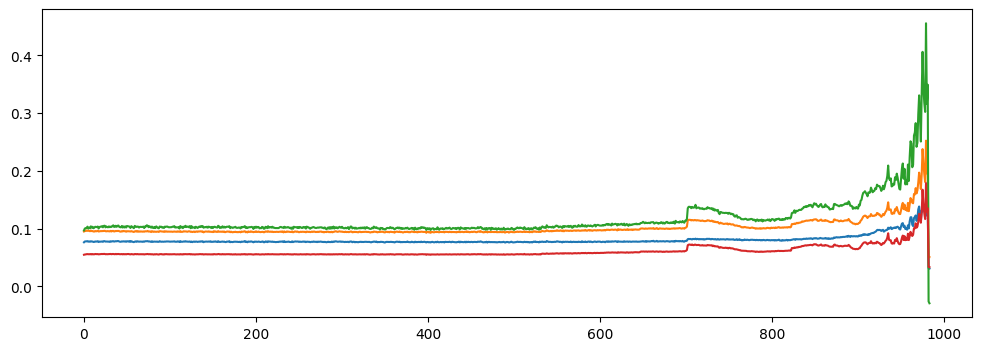

In [470]:
plt.figure(figsize=(12,4))
plt.plot(tsScore_arr)
plt.show()

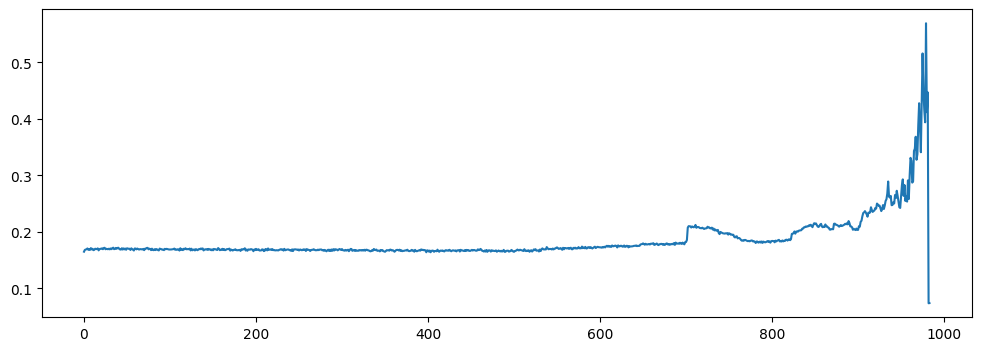

In [471]:
plt.figure(figsize=(12,4))
plt.plot(integrated_tsScore)
plt.show()

In [473]:
# 정상/이상에 대한 기준
# 단측검정
def bootlimit(stat, bootstrap, alpha):    
    alpha = 100 - alpha*100
    samsize = len(stat)
    sampled_limit = []
    for i in range(bootstrap):
        sampled_limit.append(np.percentile(np.random.choice(stat, samsize, replace=True), alpha))
    limit = np.mean(sampled_limit)
    return(limit)

cl = bootlimit(integrated_trScore, bootstrap=100, alpha=0.05)

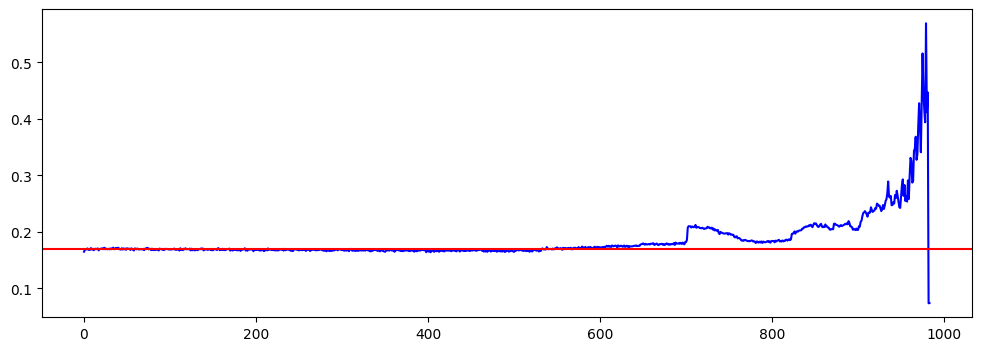

In [499]:
outidx = np.where(integrated_tsScore>cl)[0]

plt.figure(figsize=(12,4))
plt.plot(integrated_tsScore, color='blue')
# plt.plot(outidx, np.repeat(max(integrated_tsScore)*1.1, len(outidx)), 'x', color='red', alpha=0.5)
plt.axhline(y=cl, color='red')

# for idx in outidx:
  #   plt.axvline(x=idx, color='red', linestyle='-', alpha=0.1)
plt.show()

## Degradation Factor

In [493]:
l2norm_trScore = np.sqrt(np.sum(trScore_arr**2, axis=1))
tr_degScore = np.cumsum(l2norm_trScore) / np.arange(1,401,1)

l2norm_tsScore = np.sqrt(np.sum(tsScore_arr**2, axis=1))
ts_degScore = np.cumsum(l2norm_tsScore) / np.arange(1,985,1)

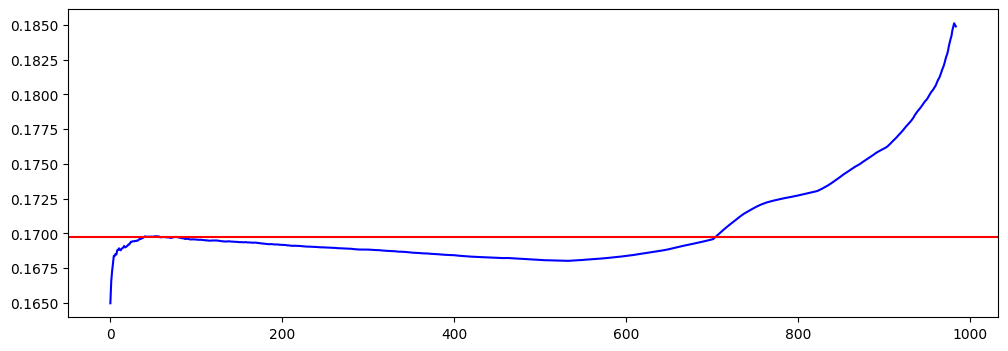

In [497]:
cl = bootlimit(tr_degScore, alpha=0.05, bootstrap=100)

plt.figure(figsize=(12,4))
plt.plot(ts_degScore, color='blue')
plt.axhline(y=cl, color='red')
plt.show()

## RUL Prediction (Exponentially Weighted Linear Regression)

In [537]:
# exponential weight
def exponential_weight(length, alpha):
    exp_weight = []
    for i in range(1, length+1):
        w = alpha * (1-alpha)**i
        exp_weight.append(w)
    exp_weight = sorted(exp_weight, reverse=False)
    return(exp_weight)

In [707]:
# Exponentially Weighted Linear Regression
t = 900
w = exponential_weight(length=t, alpha=0.05)
x = np.arange(t).reshape(t,1)
y = tsdat[0:t].reshape(t,1)

EWLR = LinearRegression(fit_intercept=True)
EWLR.fit(x,y, sample_weight = w)

coef = EWLR.coef_
intercept = EWLR.intercept_

In [696]:
# predefined failure threshold
failure_threshold = max(ts_degScore)

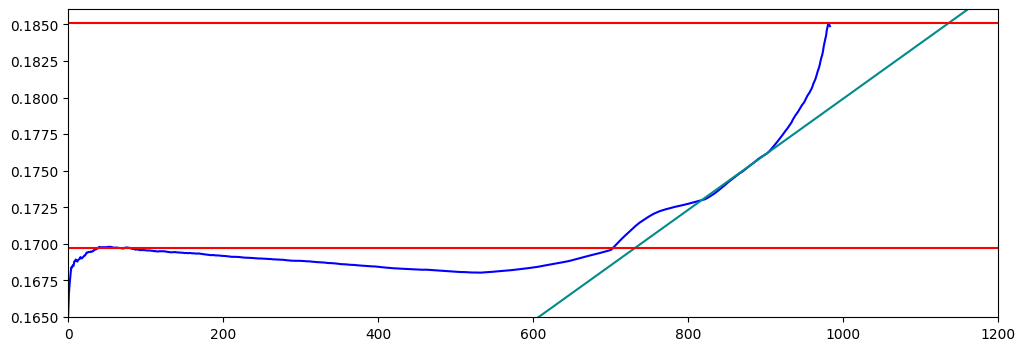

In [706]:
# Visualization of RUL Prediction
cl = bootlimit(tr_degScore, alpha=0.05, bootstrap=100)

plt.figure(figsize=(12,4))
plt.plot(ts_degScore, color='blue')

plt.xlim([0, 1200])
plt.ylim([min(ts_degScore), max(ts_degScore)*1.005])

x = np.arange(1400)
linear_curve = coef*x + intercept
plt.plot(linear_curve[0], color='darkcyan')

plt.axhline(y=failure_threshold, color='red')
plt.axhline(y=cl, color='red')
plt.show()

In [717]:
# Result of RUL Prediction
predicted_failureTime= int((failure_threshold-intercept) / coef)
RUL = predicted_failureTime-t


print('예측 잔여시점: %2.2f시점' % RUL)
print('예측 잔여수명: %2.4f일' % (RUL*10/60/24))
print()
print('실제 잔여시점: %2.2f시점' % (984-t))
print('실제 잔여수명: %2.4f일' % ((984-t)*10/60/24))

예측 잔여시점: 236.00시점
예측 잔여수명: 1.6389일

실제 잔여시점: 84.00시점
실제 잔여수명: 0.5833일
